# Beyond Counting Individual Words: N-grams


So far in our journey through text data processing, we've dealt with counting individual words. While this approach, often referred to as a "bag of words" model, can provide a basic level of understanding and can be useful for certain tasks, it often falls short in capturing the true complexity and richness of language. This is mainly because it treats each word independently and ignores the context and order of words, which are fundamental to human language comprehension.

For example, consider the two phrases  
*"The movie is good, but the actor was bad."*  
and  
*"The movie is bad, but the actor was good."*  

If we simply count individual words, both phrases are identical because they contain the exact same words!
However, their meanings are diametrically opposed. The order of words and the context in which they are used are important.

## N-grams

**N-grams** are continuous sequences of n items in a given sample of text or speech. In the context of text analysis, an item can be a character, a syllable, or a word, although words are the most commonly used items. The integer *n* in "n-gram" refers to the number of items in the sequence, so a bigram (or 2-gram) is a sequence of two words, a trigram (3-gram) is a sequence of three words, and so on.

To illustrate, consider the two sentences above.
With 3-grams we could also get the pieces "movie is good", "movie is bad", "actor was bad", and "actor was good".
Bigrams (or 2-grams) would not catch those differences. But they can also be very helpful in cases such as "don't like" vs "do like".

Now we will see how we can make use of such n-grams.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer

## N-grams in TF-IDF Vectors

When creating TF-IDF vectors, we can incorporate the concept of n-grams. The scikit-learn `TfidfVectorizer` provides the `ngram_range` parameter that allows us to specify the range of n-grams to include in the feature vectors.

### Dataset - Madrid Restaurant Reviews
We will now use a large, text-based dataset containing more than 176.000 restaurant reviews from Madrid ([see dataset on zenodo](https://zenodo.org/records/6583422)). The dataset (about 142MB) can be downloaded via the following code block.

In [2]:
"""
This code block downloads the data from zenodo and stores it in a local 'datasets' folder.
"""

import requests
import os


def download_from_zenodo(url, save_path):
    """
    Downloads a file from a given Zenodo link and saves it to the specified path.

    Parameters:
    - url: The Zenodo link to the file to be downloaded.
    - save_path: Path where the file should be saved.
    """

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File {save_path} already exists. Skipping download.")
        return None

    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File downloaded successfully and saved to {save_path}")


# Zenodo link to the dataset
zenodo_link = r"https://zenodo.org/records/6583422/files/Madrid_reviews.csv?download=1"

# Path to save the downloaded dataset (you can modify this as needed)
output_path = os.path.join("..", "datasets", "madrid_reviews.csv")

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Download the dataset
download_from_zenodo(zenodo_link, output_path)

File ..\datasets\madrid_reviews.csv already exists. Skipping download.


In [3]:
filename = "../datasets/madrid_reviews.csv"
data = pd.read_csv(filename)
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...","December 10, 2019",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,"August 23, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,"March 6, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,"September 29, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,"July 27, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


In [4]:
data.shape

(176848, 12)

In [5]:
data.review_full[2]

'I had the yuca profiteroles and the veggie burger, by recommendation of the server. It was absolutely delicious and the service was outstanding. I will definitely be back again with friends !'

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# considers both unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(176848, 1496963)

This way, we are not just considering the frequency of individual words, but also the frequency of sequences of words, which often capture more meaning than the individual words alone.

**But:** this creates even bigger tfidf vectors!  
Now we end up with vectors of about 1 million entries (even though most will be zero most of the time).

## TF-IDF with Bigrams: Growing Vectors and Managing High Dimensionality

The power of n-grams comes at a cost. Specifically, as we increase the size of our n-grams, the dimensionality of our feature vectors also increases. In the case of bigrams, for every pair of words that occur together in our text corpus, we add a new dimension to our feature space. This can quickly lead to an explosion of features. For instance, a modest vocabulary of 1,000 words leads to a potential of 1,000,000 (1,000 x 1,000) bigrams.

This high dimensionality can lead to two issues:

1. **Sparsity:** Most documents in the corpus will not contain most of the possible bigrams, leading to a feature matrix where most values are zero, i.e., a sparse matrix.
2. **Computational resources:** The computational requirement for storing and processing these feature vectors can become significant, especially for large text corpora.

Several techniques can help manage this high-dimensionality problem:

- **Feature selection:** We can limit the number of bigrams we include in our feature vector. This could be done based on the frequency of the bigrams. For example, we could choose to include only those bigrams that occur more than a certain number of times in the corpus.
- **Dimensionality reduction:** Techniques such as Principal Component Analysis (PCA) or Truncated Singular Value Decomposition (TruncatedSVD) can be used to reduce the dimensionality of the feature space, while preserving as much of the variance in the data as possible.
- **Using Hashing Vectorizer:** Scikit-learn provides a `HashingVectorizer` that uses a hash function to map the features to indices in the feature vector. This approach has a constant memory footprint and does not require to keep a vocabulary dictionary in memory, which makes it suitable for large text corpora.

It's important to weigh the trade-offs between capturing more context using n-grams and managing the resulting high dimensionality.

Let us here use the simplest way to reduce the tfidf vector size: a more restrictive feature selection!

In [7]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             ngram_range=(1, 2))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(176848, 119341)

This looks much better! Maybe we can even include 3-grams?

In [8]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.25,
                             ngram_range=(1, 3))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(176848, 481562)

This looks OK, at least size-wise. The reason why this doesn't explode in terms of vector size is that the `min_df` parameter also counts for 2-grams, 3-grams etc. This here means that only the 3-grams which occur at least `min_df`-times will be kept.

Now we should check which ngrams the tfidf model finally included.

In [9]:
vectorizer.get_feature_names_out()[-100:]

array(['zone of the', 'zone so', 'zones', 'zoo', 'zoo and', 'zoomed',
       'zucca', 'zucchini', 'zucchini and', 'zucchini carpaccio',
       'zucchini flowers', 'zucchini ravioli', 'zucchini salad',
       'zucchini salad and', 'zucchini soup', 'zucchini which',
       'zucchini with', 'zuchini', 'zuma', 'zumo', 'zumo de',
       'zumo de naranja', 'zurbano', 'ángel', 'área', 'ástor', 'ático',
       'él', 'époque', 'ñeru', 'ôven', 'último', 'único', 'über', 'очень',
       'אוכל', 'מאוד', 'מומלץ', 'جدا', '가격도', '같아요', '같이', '굉장히', '그리고',
       '너무', '다른', '다시', '덕분에', '마드리드', '마드리드에', '마드리드에서', '많이', '맛있게',
       '맛있고', '맛있습니다', '맛있어요', '맛있었습니다', '맛있었어요', '매우', '먹고', '먹었는데',
       '먹었습니다', '먹을', '메뉴', '모두', '바로', '보다', '빠에야', '상그리아', '스페인',
       '시켰는데', '식당', '여기', '여행', '원래', '음식', '음식도', '음식이', '입맛에', '있는',
       '있어서', '저희', '정말', '조금', '좋아요', '좋았어요', '좋은', '직원들도', '직원분이', '진짜',
       '추천', '추천합니다', '친절하게', '친절하고', '친절합니다', '특히', '한국인', '한국인 입맛에',
       '함께', '해서'], dtype

In [10]:
vectorizer.get_feature_names_out()[-1]

'해서'

Well, that does not always immediately look like very good word combinations.
We do see a lot of 2-grams and 3-grams. Most combinations of 2 or 3 words, however, seem to be grammatically wrong.

Why is that?

The reason is that our selection criteria (using `min_df` and `max_df`) removed a lot of very common words so that **yes it does** becomes **yes does**.

But we can leave it to the machine learning algorithms now to make more sense of it.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.review_full, data.rating_review, test_size=0.2, random_state=0)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")    

Train dataset size: (141478,)
Test dataset size: (35370,)


In [12]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=10000,
                             #ngram_range=(1, 2)
                            )  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(141478, 10000)

In [13]:
vectorizer.get_feature_names_out()[-100:]

array(['worried', 'worries', 'worry', 'worse', 'worst', 'worth', 'worths',
       'worthwhile', 'worthy', 'woth', 'would', 'wouldn', 'wouldnt',
       'wound', 'wow', 'wowed', 'wrap', 'wrapped', 'wrapping', 'wraps',
       'write', 'writer', 'writers', 'writing', 'written', 'wrong',
       'wrongly', 'wrote', 'wrought', 'wth', 'www', 'x2', 'ximenez',
       'xmas', 'xo', 'xx', 'ya', 'yaki', 'yakisoba', 'yakitori',
       'yakitoro', 'yam', 'yamil', 'yang', 'yards', 'yeah', 'year',
       'years', 'yell', 'yelled', 'yelling', 'yellow', 'yelp', 'yep',
       'yerbabuena', 'yes', 'yesterday', 'yet', 'yo', 'yoghurt', 'yogurt',
       'yolk', 'york', 'young', 'younger', 'youngest', 'youngsters',
       'your', 'youre', 'yours', 'yourself', 'yourselves', 'youthful',
       'youtube', 'yr', 'yrs', 'yuca', 'yucca', 'yuck', 'yum', 'yumm',
       'yummie', 'yummy', 'yuzu', 'zalacain', 'zamburinas', 'zamburiñas',
       'zara', 'zen', 'zenith', 'zerain', 'zero', 'zone', 'zones', 'zoo',
       'zu

This time we will start right away with a classification model:

### Logistic Regression model

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)  # don't worry it also works without setting max_iter
model.fit(tfidf_vectors, y_train)

C:\Users\flori\anaconda3\envs\data_science\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [15]:
tfidf_vectors_test = vectorizer.transform(X_test)
predictions = model.predict(tfidf_vectors_test)

In [16]:
np.round(predictions[:20], 1)

array([4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 4, 5, 5],
      dtype=int64)

In [17]:
y_test[:20].values

array([5, 5, 4, 5, 3, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 3, 5, 5, 5, 5],
      dtype=int64)

Text(0.5, 0, 'prediction error')

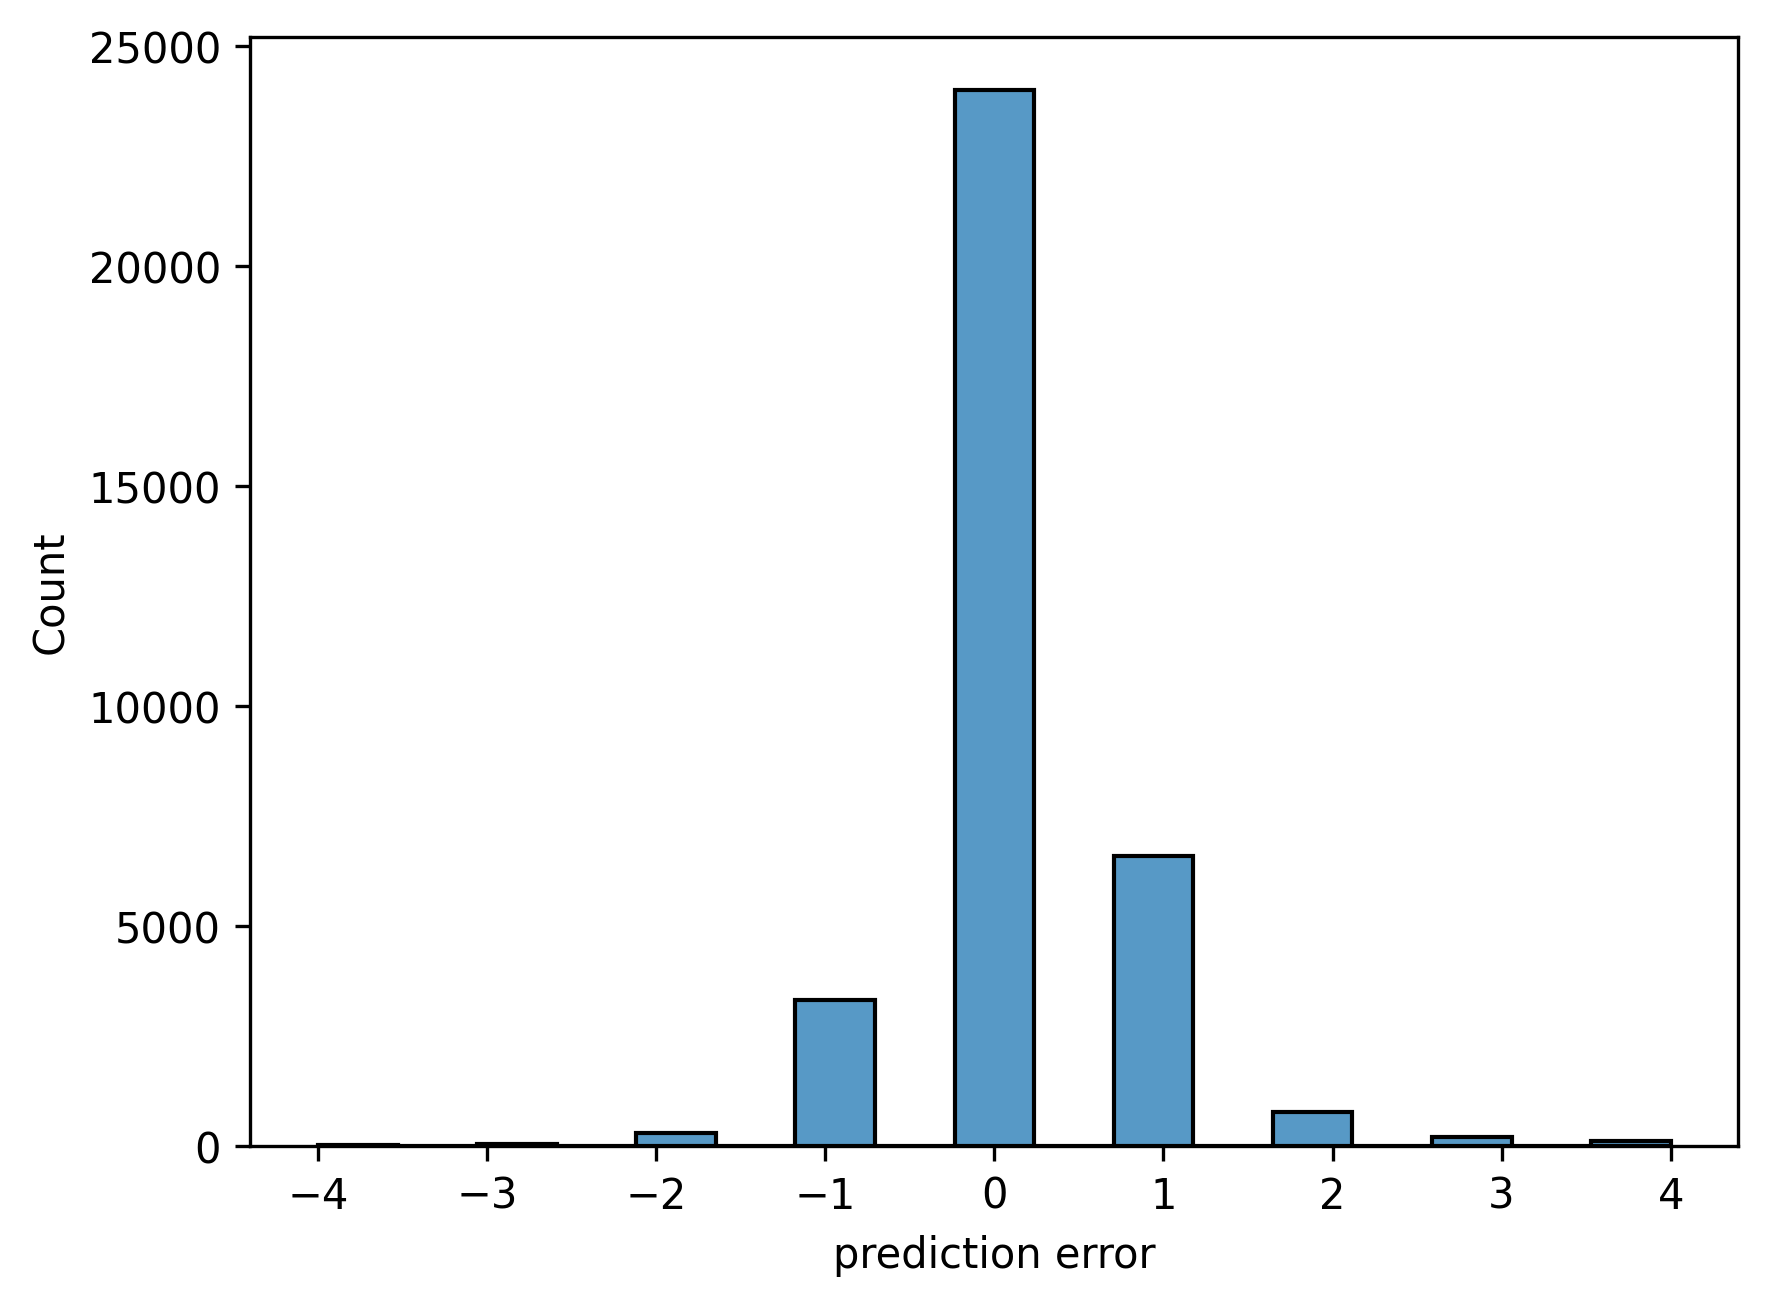

In [18]:
plt.figure(dpi=300)
sb.histplot(predictions - y_test)
plt.xlabel("prediction error")

In [19]:
# mean absolute error:
np.abs(predictions - y_test).mean()

0.378117048346056

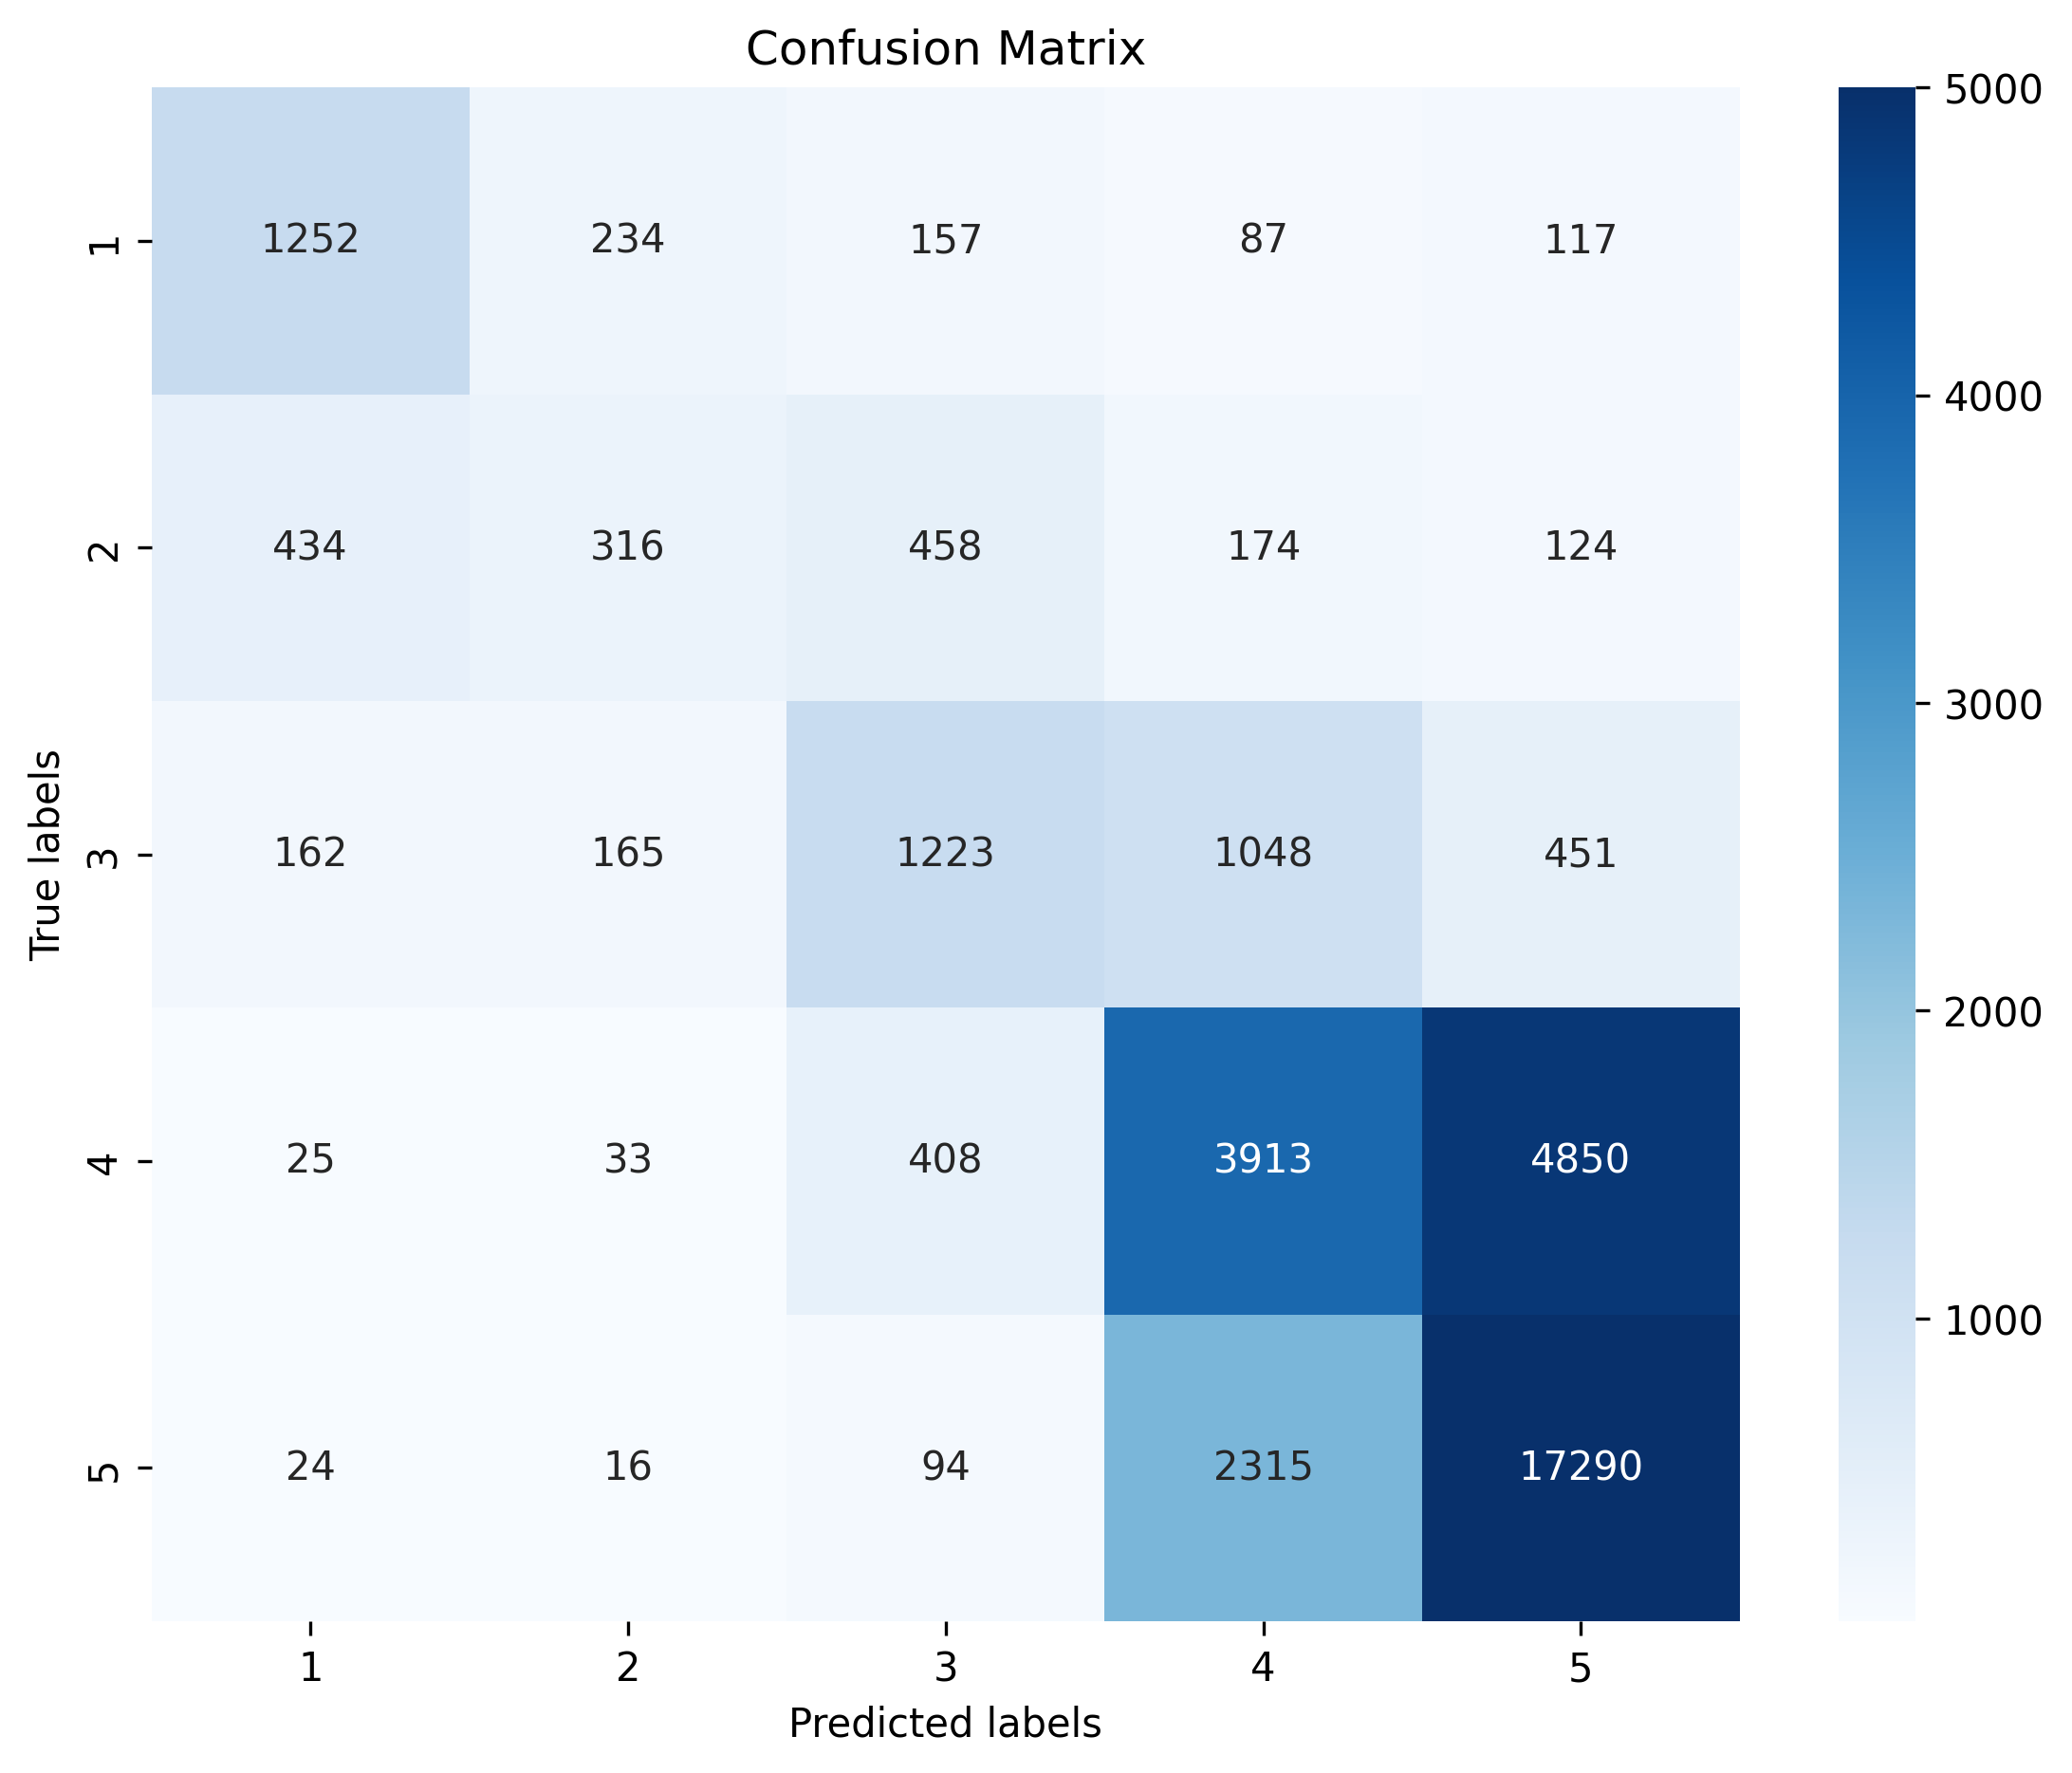

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_,
           vmax=5000
          )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=10000,
                             ngram_range=(1, 3))  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(141478, 10000)

In [22]:
vectorizer.get_feature_names_out()[-100:]

array(['you are not', 'you ask', 'you ask for', 'you can', 'you can also',
       'you can buy', 'you can choose', 'you can eat', 'you can enjoy',
       'you can find', 'you can get', 'you can go', 'you can have',
       'you can order', 'you can see', 'you can sit', 'you can try',
       'you cannot', 'you choose', 'you come', 'you could', 'you do',
       'you do not', 'you don', 'you don want', 'you eat', 'you enjoy',
       'you enter', 'you expect', 'you feel', 'you feel like', 'you find',
       'you for', 'you get', 'you get the', 'you go', 'you go to',
       'you have', 'you have the', 'you have to', 'you in', 'you just',
       'you know', 'you like', 'you ll', 'you ll be', 'you ll find',
       'you love', 'you make', 'you may', 'you might', 'you must',
       'you must try', 'you need', 'you need to', 'you order', 'you pay',
       'you pay for', 'you re', 'you re in', 'you re looking',
       'you re not', 'you really', 'you see', 'you should', 'you sit',
       'you the'

#### Question!
Why did we now get a notably smaller tfidf vector length?

In [23]:
tfidf_vectors[0, :].data

array([0.1387891 , 0.13512541, 0.14732539, 0.11708958, 0.14946676,
       0.11511072, 0.1444836 , 0.13665878, 0.14979188, 0.10268665,
       0.08515603, 0.12004832, 0.10720641, 0.11965181, 0.12394399,
       0.092254  , 0.14979188, 0.11356895, 0.10914472, 0.14331753,
       0.09882652, 0.10212461, 0.09038474, 0.09779526, 0.09394805,
       0.14525597, 0.12540266, 0.13598151, 0.12847323, 0.14875365,
       0.11584212, 0.11375017, 0.11152386, 0.12644517, 0.1377188 ,
       0.07982853, 0.05498834, 0.13392387, 0.11242216, 0.14367861,
       0.1499564 , 0.14313935, 0.1202977 , 0.07495173, 0.14612707,
       0.11327957, 0.13124683, 0.056673  , 0.05969443, 0.1270542 ,
       0.08700208, 0.14599061, 0.07204574, 0.1137082 , 0.08188261,
       0.10429517, 0.08306113, 0.07947322, 0.07596308, 0.12319629,
       0.09291383, 0.09143116, 0.10948931, 0.178938  , 0.12462447,
       0.09796248, 0.10013418, 0.11864844, 0.11132398, 0.08634848,
       0.09937276, 0.09949771, 0.08454477, 0.05570801, 0.09212

In [24]:
tfidf_vectors[0, :].indices

array([8292, 3801, 7590, 9155, 9260, 4170, 9254, 3032, 4240, 9844, 6542,
       6429, 8291, 7868, 6832, 3800, 9342, 3792, 2735, 4848, 7587, 5121,
       2055, 9154, 1465,  938, 6612, 9259, 3320, 1125, 5068, 9866,  704,
       8424, 7817, 9058, 4141, 6406, 9252, 5394, 1433, 5585, 7626, 3029,
       4452, 1015, 9813, 5396, 4223, 4715, 6426, 5932, 2410, 9826, 6831,
       9340, 2511, 4845, 2052, 4822, 4333, 6610, 1111, 9843, 8443, 8423,
       8523, 4263,  212, 2208, 6403, 5392, 5583, 3019, 4449])

In [25]:
example_vector = pd.DataFrame({
    "word": vectorizer.get_feature_names_out()[tfidf_vectors[0, :].indices],
    "tfidf": tfidf_vectors[0, :].data
})
example_vector

,word,tfidf
0,to say that,0.138789
1,in spain and,0.135125
2,the most expensive,0.147325
3,we did not,0.117090
4,we should have,0.149467
...,...,...
70,sat,0.099373
71,once,0.099498
72,outside,0.084545
73,from,0.055708


This time we will start right away with a classification model:

### Logistic Regression model

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)  # don't worry it also works without setting max_iter
model.fit(tfidf_vectors, y_train)

C:\Users\flori\anaconda3\envs\data_science\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [27]:
tfidf_vectors_test = vectorizer.transform(X_test)
predictions = model.predict(tfidf_vectors_test)

In [28]:
np.round(predictions[:20], 1)

array([4, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 5, 5],
      dtype=int64)

In [29]:
y_test[:20].values

array([5, 5, 4, 5, 3, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 3, 5, 5, 5, 5],
      dtype=int64)

Text(0.5, 0, 'prediction error')

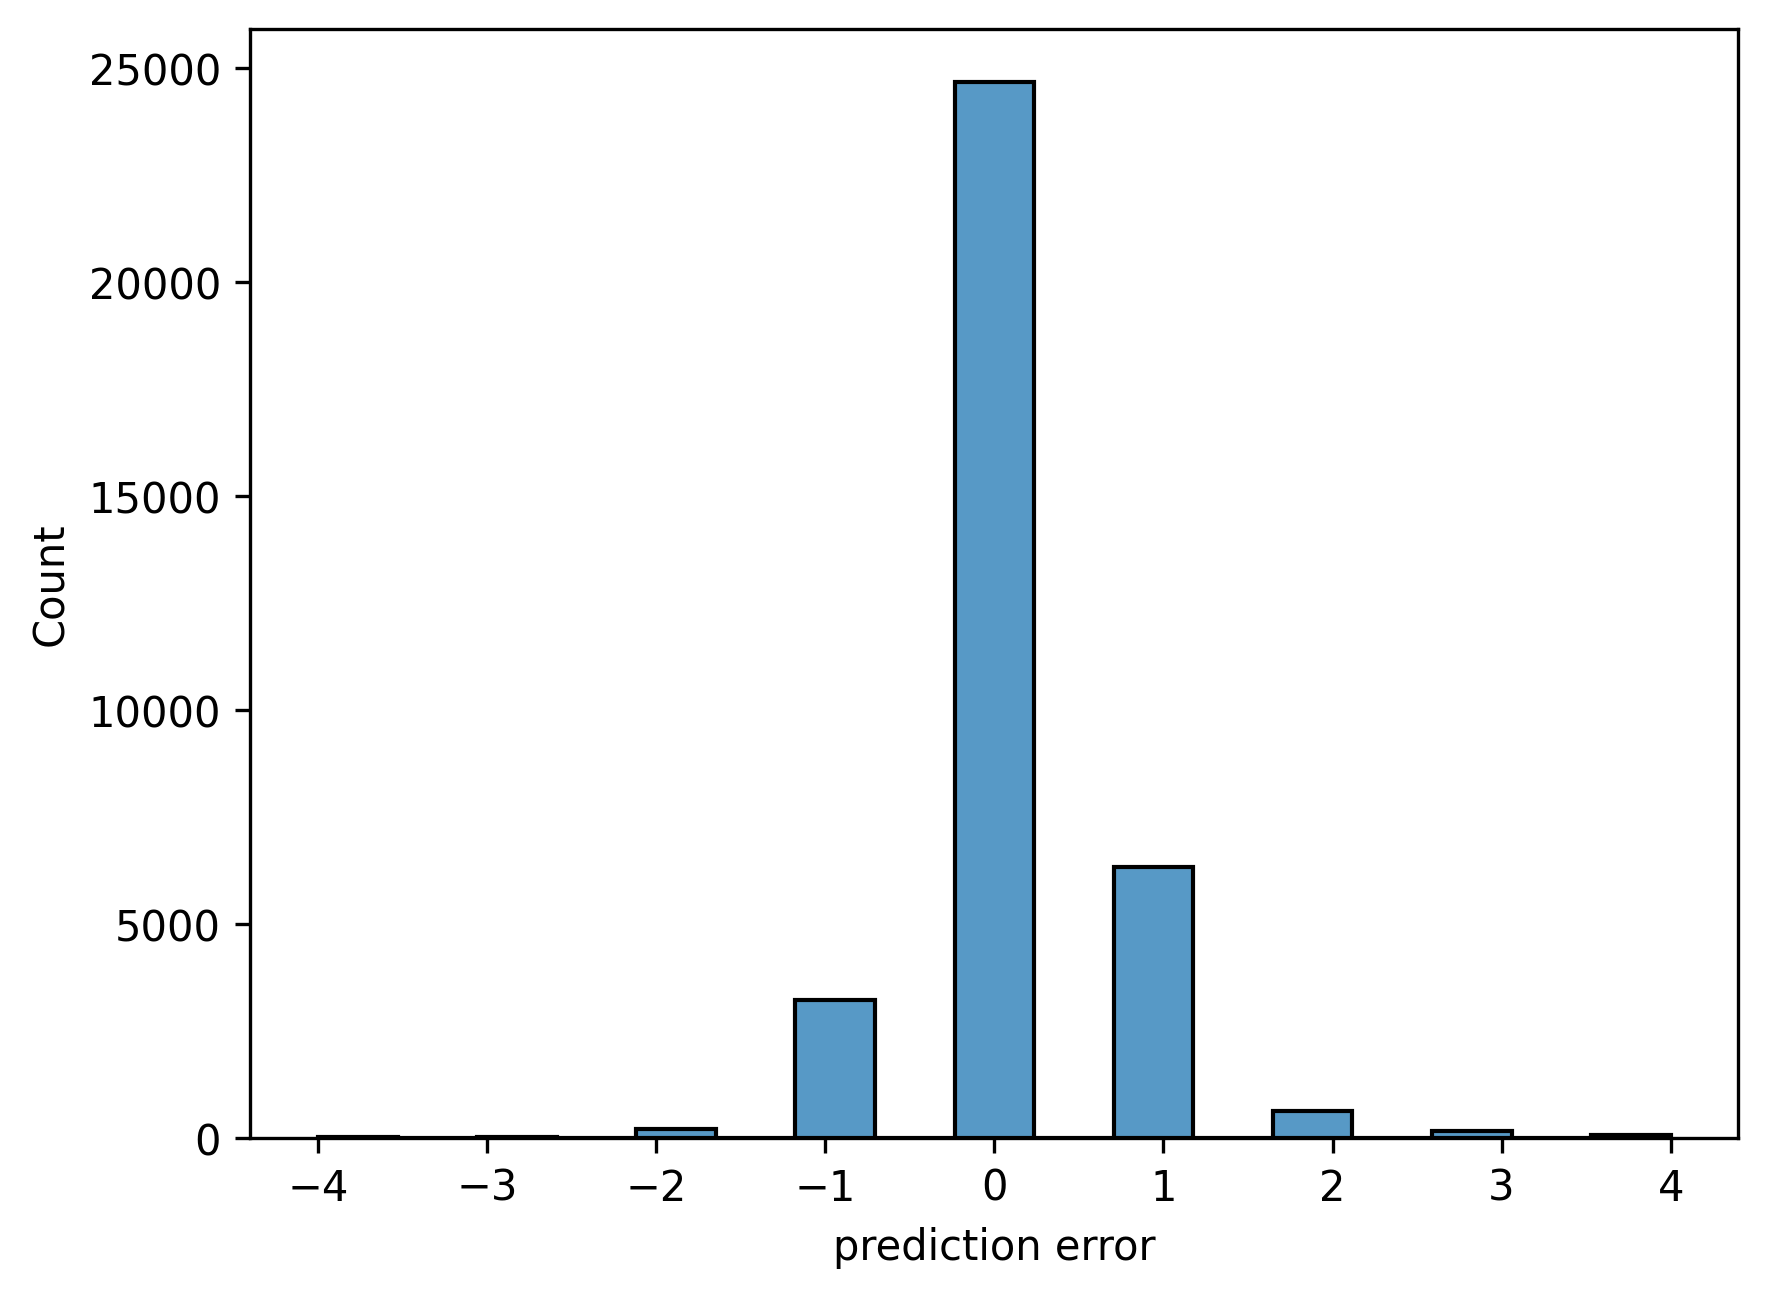

In [30]:
plt.figure(dpi=300)
sb.histplot(predictions - y_test)
plt.xlabel("prediction error")

In [31]:
# mean absolute error:
np.abs(predictions - y_test).mean()

0.34662143059089623

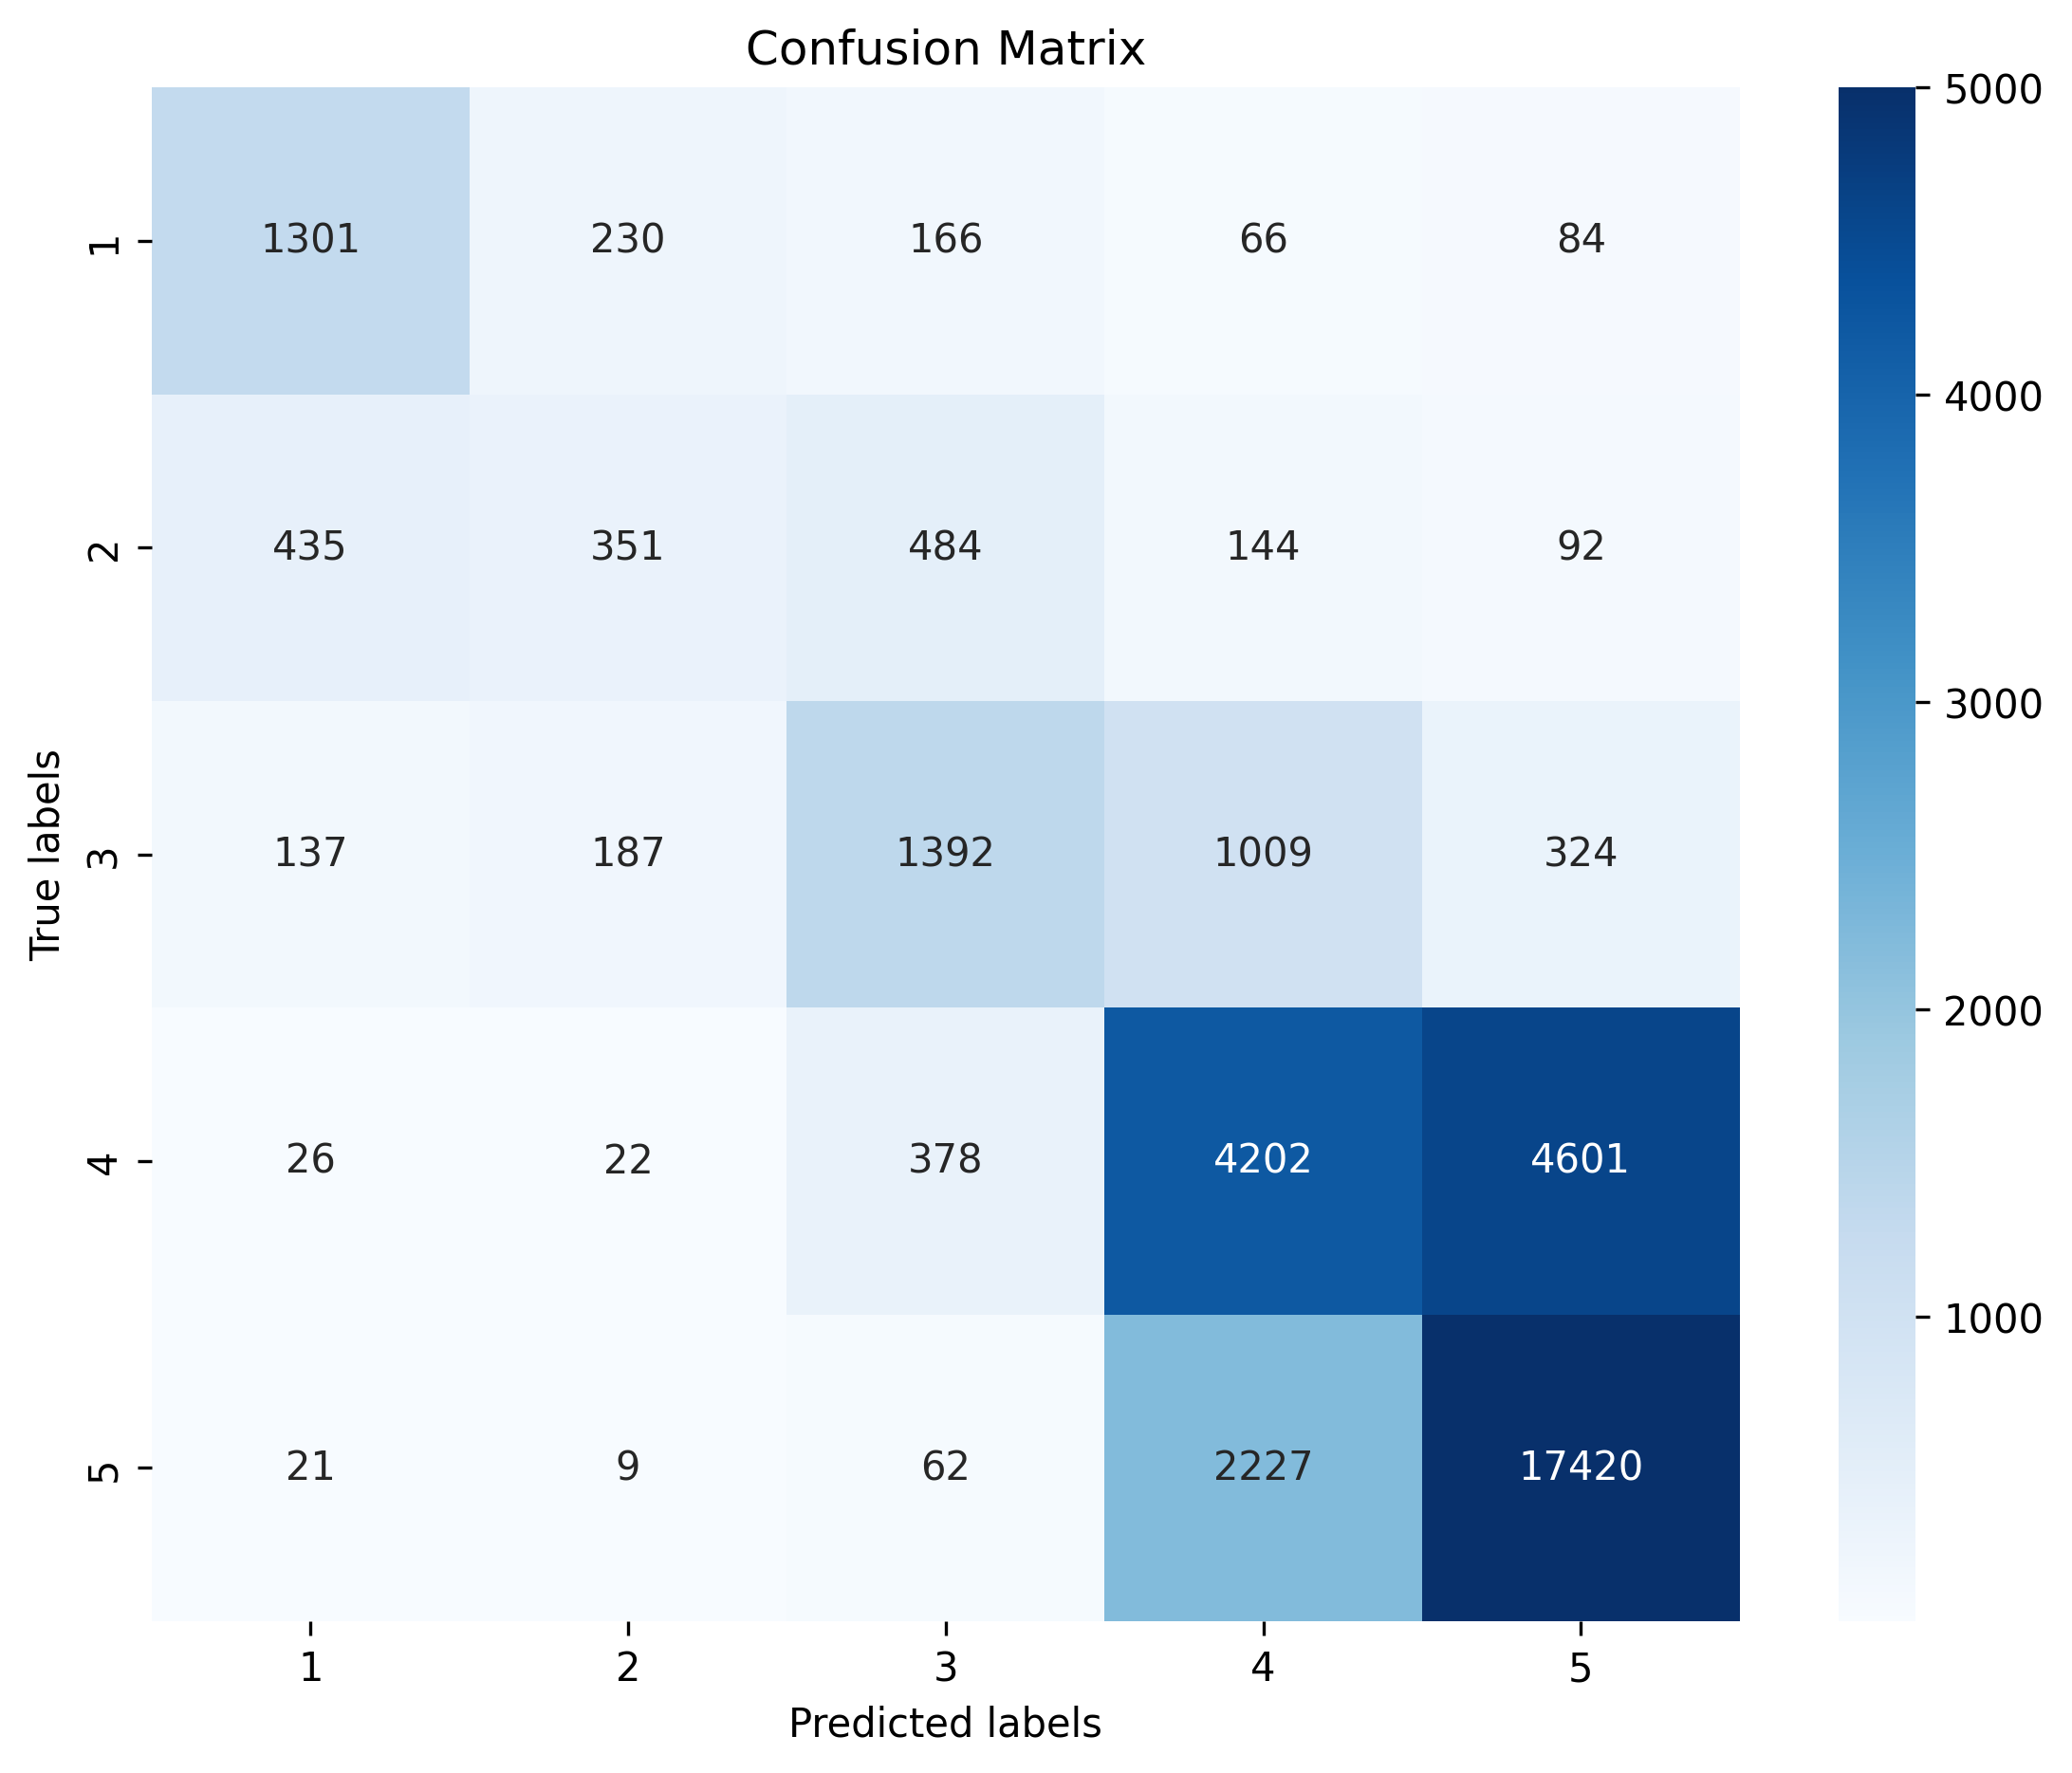

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_,
           vmax=5000
          )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Did the 2-grams and 3-grams help?
Well, the prediction accuracy only got slightly better. So, it seems to have *some* effect, but nothing spectacular. However, this is not a general finding and might look very differently for other datasets or problems.

We can now also look at the ngrams that have the largest impact on the model predictions:

In [33]:
ngrams = pd.DataFrame({"ngram": vectorizer.get_feature_names_out(),
                       "weight": model.coef_[0]
                      })
ngrams.sort_values("weight")

,ngram,weight
2008,delicious,-5.684107
2477,excellent,-5.177781
8694,very good,-4.934601
7185,tasty,-3.622168
8954,was good,-3.573100
...,...,...
3619,horrible,5.520862
1015,avoid,5.901747
6344,rude,5.938042
9826,worst,6.544302


Here, too, we find only very few 2-grams in the top-20 and bottom-20 lists. Most of the times, the model still seems to judge the reviews based on individual words.

In [34]:
ngrams.sort_values("weight").head(20)

,ngram,weight
2008,delicious,-5.684107
2477,excellent,-5.177781
8694,very good,-4.934601
7185,tasty,-3.622168
8954,was good,-3.573100
2987,friendly,-3.551191
1272,bit,-3.392709
248,amazing,-3.365730
7327,the best,-3.301114
4991,nice,-3.180537


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 1301   230   166    66    84]
 [  435   351   484   144    92]
 [  137   187  1392  1009   324]
 [   26    22   378  4202  4601]
 [   21     9    62  2227 17420]]
              precision    recall  f1-score   support

           1       0.68      0.70      0.69      1847
           2       0.44      0.23      0.30      1506
           3       0.56      0.46      0.50      3049
           4       0.55      0.46      0.50      9229
           5       0.77      0.88      0.82     19739

    accuracy                           0.70     35370
   macro avg       0.60      0.55      0.56     35370
weighted avg       0.68      0.70      0.68     35370



### Confusion matrix
The confusion matrix can tell us a lot about where the model works well and where it fails. Often is is more accessible if the matrix is plotted, for instance using seaborns `heatmap`.

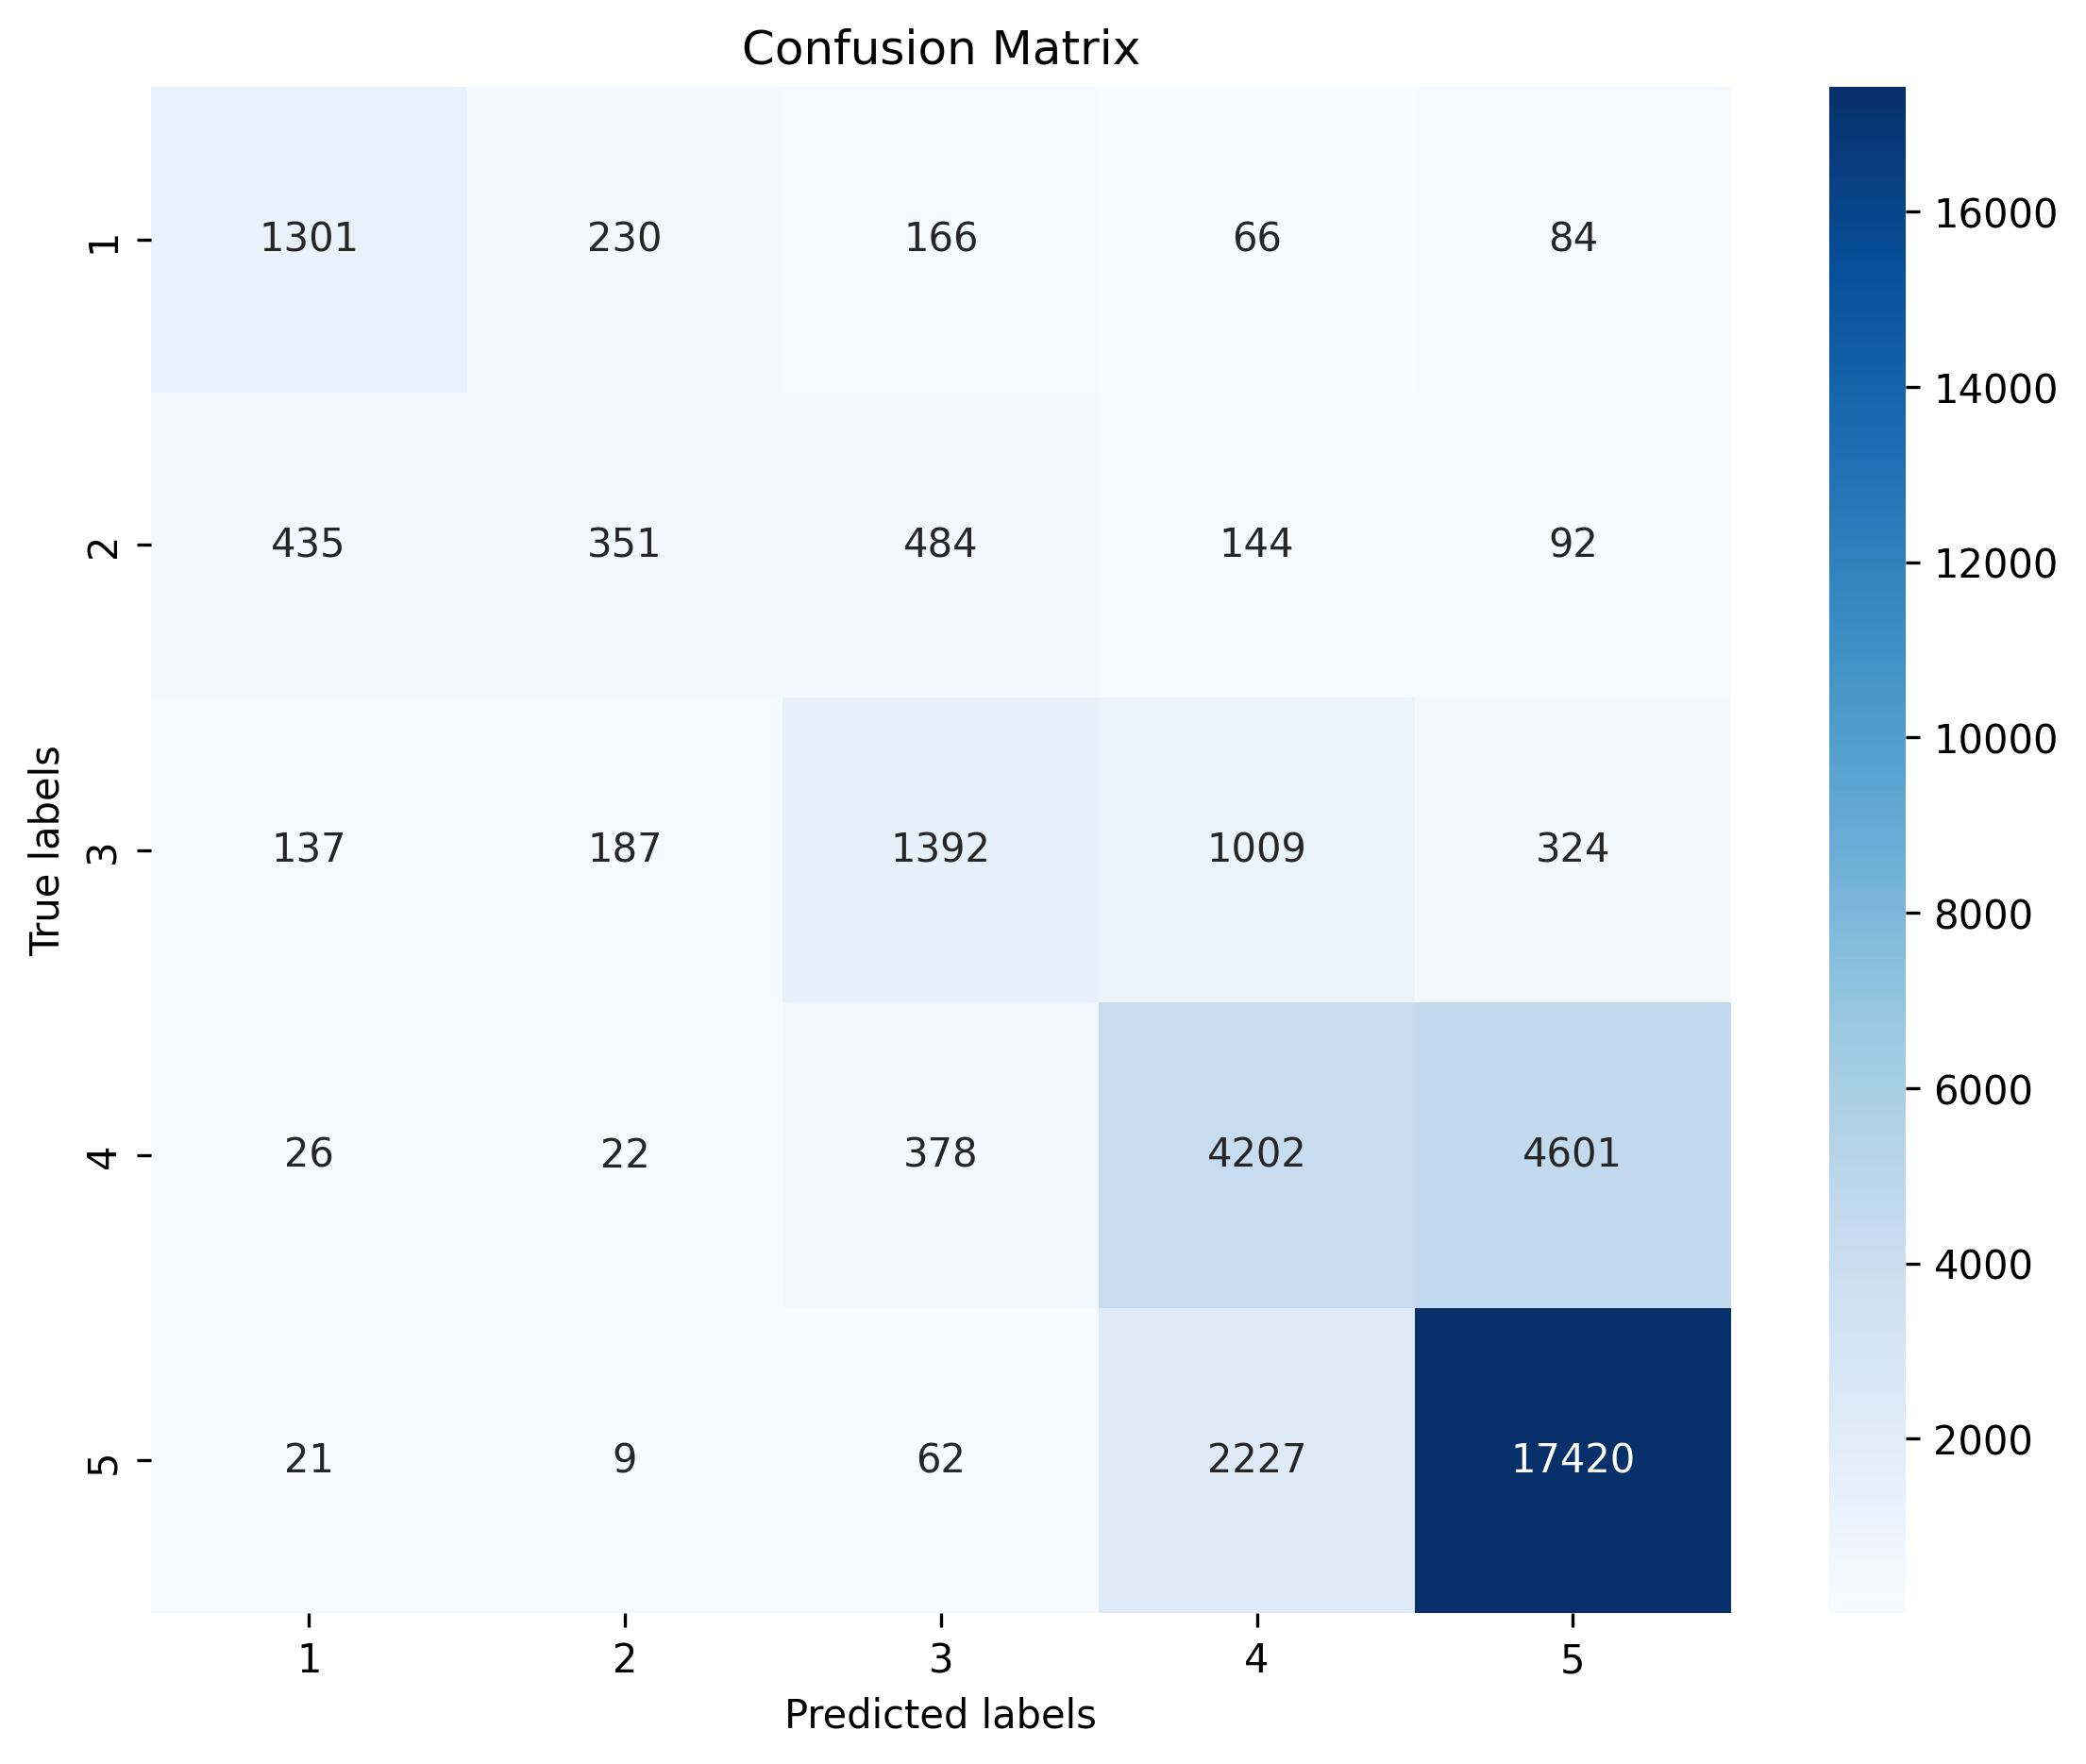

In [36]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Find similar documents with tfidf
So far, we used the tfidf-vectors as feature vectors to train machine learning models. As we just saw, this works very well to predict review rating or to classify documents as positive/negative (=sentiment analysis).

But there is more we can do with tfidf vectors.
Why not use the vectors to compute distances or similarities? This way, we can search for the most similar documents in a corpus!

In [37]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=50000,
                             ngram_range=(1, 3))  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(141478, 50000)

In [38]:
tfidf_vectors.shape

(141478, 50000)

In [39]:
X_train.shape

(141478,)

#### Compare one vector to all other vectors
Even though we here deal with very large vectors, computing similarities or angles between these vectors is compuationally very efficient. This means, we can simply compare a the tfidf vector of a given text to all > 140,000 documents in virtually no time!

In order for this to work, however, we should not rely on for-loops. Those are inherently slow in Python. We rather use optimized functions for this such as from `sklear.metrics.pairwise`.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

review_id = -11#-9#-2
query_vector = tfidf_vectors[review_id, :]

cosine_similarities = cosine_similarity(query_vector, tfidf_vectors).flatten()
cosine_similarities.shape

(141478,)

In [41]:
np.sort(cosine_similarities)[::-1]

array([1.        , 0.36692149, 0.31812401, ..., 0.        , 0.        ,
       0.        ])

In [42]:
np.argsort(cosine_similarities)[::-1]

array([141467,  94876,  91939, ...,  95683,  43090, 104856], dtype=int64)

In [43]:
top5_idx = np.argsort(cosine_similarities)[::-1][1:6]
top5_idx

array([ 94876,  91939, 103516,  47460,  51098], dtype=int64)

Let us now look at the results of our search by displaying the top-5 most similar documents (according to the cosine score on the tfidf-vectors). This usually doesn't work perfectly, but it does work to quite some extent. Try it out yourself and have a look at what documents this finds for you!

In [44]:
print("\n****Original document:****")
print(X_train.iloc[review_id])

for i in top5_idx:
    print(f"\n----Document with similarity {cosine_similarities[i]:.3f}:----")
    print(X_train.iloc[i])


****Original document:****
The food was great, the staff were friendly. The place was not crowded. The location was very convenient, while hidden from the hustle and bustle.

----Document with similarity 0.367:----
Takes you away from the hustle and bustle of the city ! Lovely setting.Recommend the sangria cocktails.

----Document with similarity 0.318:----
Cute little spot away from the hustle and bustle. We enjoyed the most delicious little cake (Tigre chocolate) and hot chocolate. Friendly service as well!

----Document with similarity 0.309:----
Stopped off for a quick drink, great little place away from the hustle and bustle. Tasty complimentary tortilla, didn't have a meal, but food looked great Would come back.

----Document with similarity 0.307:----
This taberna is nestled away from the hustle and bustle, but close to Palacio Real. Very authentic and local. Go hungry, cocido madrileño is not for the faint of heart.

----Document with similarity 0.298:----
Perfect dinner spot 

## Word Vectors: Word2Vec and Co
**Tfidf vectors** are a rather basic, but still often used, technique. Arguably, this is because they are based on relatively simple statistics and easy to compute. They typically do a good job in weighing words according to their importance in a larger corpus and allow us to ignore words with low *distriminative power* (for instance so-called *stopwords* such as "a", "the", "that", ...).

With **n-grams** we can even go one step further and also count sentence pieces longer than one word. With n-grams our models can identify important word combinations such as negations ("do not like"), comparatives, or specific expressions ("the best") into account. The price, however, is that we have to restrict the number of n-grams to avoid exploding vector sizes.

TF-IDF vectors and n-grams serve as powerful techniques to represent and manipulate text data, but they have limitations. These methods treat words, or tiny groups of words, as individual, isolated units, devoid of any context or relation to other words. In other words, they cannot capture the semantic meanings of words and the linguistic context in which they are used.

Take these two sentences as an example:

(1) *The customer likes cake with a cappuccino.*  
(2) *The client loves to have a cookie and a coffee.*

We will immediately identify that both sentences speak of very similar things. But if you look at the words in both sentences you will realize that only *"The"* and *"a"* are found in both. And, as we have seen in the tfidf-part, such words tell very little about the sentence content. All other words, however, only occur in one or the other sentence. Tfidf-vectors would compute a zero similarity here.

This is where we come to **word vectors**. Word vectors, also known as **word embeddings**, are mathematical representations of words in a high-dimensional space where the semantic similarity between words corresponds to the geometric distance in the embedding space. Simply put, similar words are close together, and dissimilar words are farther apart. If done well, this should show that *"cookie"* and *"cake"* are not the same word, but mean something very related.

The most prominent example of such a technique is **Word2Vec** {cite}`mikolov_distributed_2013`{cite}`mikolov_efficient_2013`.

### Word2Vec

The fundamental idea behind Word2Vec is to use the context in which words appear to learn their meanings. As shown in the {numref}`fig_word2vec_sliding_window`, a sliding window of a fixed size (in this case, 5) moves across the sentence "The customer likes cake with a cappuccino." At each step, the algorithm selects a target word and its surrounding context words. The goal is to predict the target word based on its context or vice versa.

For example, in the phrase "the customer likes," the target word is "the," and the context words are "customer" and "likes." This process is repeated for each possible position in the sentence. These word-context pairs are fed into the Word2Vec model, which learns to map each word to a unique vector in such a way that words appearing in similar contexts have similar vectors. This vector representation captures semantic similarities, meaning that words with similar meanings or usages are positioned closer together in the vector space. Word2Vec thus enables various applications such as sentiment analysis, machine translation, and recommendation systems by providing a mathematical representation of words that reflects their meanings and relationships.

Word2Vec models can be trained using two main methods: Continuous Bag of Words (CBOW) and Skip-Gram. In CBOW, the model predicts a target word based on its surrounding context words, focusing on understanding the word's context to infer its meaning. Conversely, the Skip-Gram model predicts the surrounding context words given a target word, emphasizing the ability to generate context from a single word {cite}`mikolov_distributed_2013`{cite}`mikolov_efficient_2013`.

```{figure} ../images/fig_word2vec_sliding_window.png
:name: fig_word2vec_sliding_window

Techniques such as Word2Vec learn vector representations of individual words based on their "context", which is given by the neighboring words. 
```


In [46]:
import nltk

tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()

def process_document(doc):
    """Convert document to lemmas."""
    tokens = tokenizer.tokenize(doc)
    tokens = [x.strip(".,;:!? ") for x in tokens]
    return [stemmer.lemmatize(w) for w in tokens]

The entire text will be divided into sentences, that will be our "documents" in Word2vec terms. To reduce the computation time we will only use a fraction of the sentences, but feel free to repeat the following code parts with all sentences.

In [47]:
from tqdm.notebook import tqdm

sentences = [process_document(doc) for doc in tqdm(X_train.values[:50_000])]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [48]:
len(sentences)

50000

We will now train our own Word2Vec model using `Gensim`, see also [documentation](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples).

In [49]:
from gensim.models import Word2Vec

# Assume 'sentences' is a list of lists of tokenized sentences
model = Word2Vec(sentences,
                 vector_size=200,
                 window=5,
                 min_count=2,
                 workers=4)

In particular when we work with very large text corpora, training models such as Word2Vec can be time consuming. Usually, we therefore want to save the trained models for later re-use.

In [50]:
model.save("word2vec_madrid_reviews.model")

In [51]:
vector = model.wv['delicious']  # get numpy vector of a word

In [52]:
# just to get an idea how these vectors look like
vector[:20]

array([-0.38687244, -1.0692282 , -1.9413655 ,  0.264635  ,  0.85302734,
       -0.97620904,  1.7627273 ,  1.4508923 ,  0.39590555, -0.5755085 ,
        0.8223221 ,  0.7494018 ,  0.7385848 ,  1.0885937 ,  0.23568982,
        1.2578772 ,  2.4391305 , -0.4542736 , -0.15326655,  1.6938208 ],
      dtype=float32)

Let's now have a look at what work similarities we can get from the Word2Vec model that we just trained on the above sentences.

In [53]:
model.wv.most_similar('delicious', topn=10)

[('tasty', 0.800070583820343),
 ('yummy', 0.7640842795372009),
 ('fantastic', 0.758423924446106),
 ('amazing', 0.7505677342414856),
 ('divine', 0.7486420273780823),
 ('superb', 0.7320771813392639),
 ('incredible', 0.7014109492301941),
 ('fabulous', 0.6964861154556274),
 ('outstanding', 0.6905204057693481),
 ('exquisite', 0.6843255758285522)]

In [54]:
model.wv.most_similar('pizza', topn=10)

[('burger', 0.7599653005599976),
 ('pasta', 0.692646324634552),
 ('hamburger', 0.6713453531265259),
 ('ramen', 0.6261649131774902),
 ('Pizza', 0.620985209941864),
 ('taco', 0.6181697249412537),
 ('salad', 0.6107888221740723),
 ('burrito', 0.6093743443489075),
 ('sushi', 0.6070583462715149),
 ('margarita', 0.6011375188827515)]

In [55]:
model.wv.most_similar('horrible', topn=10)

[('terrible', 0.878247082233429),
 ('awful', 0.8632163405418396),
 ('disgusting', 0.7798396944999695),
 ('appalling', 0.7206198573112488),
 ('OK', 0.6718139052391052),
 ('exceptional', 0.6562348008155823),
 ('okay', 0.6466514468193054),
 ('spectacular', 0.6463118195533752),
 ('bad', 0.640613853931427),
 ('ok', 0.6305819153785706)]

In [56]:
model.wv.most_similar('friendly', topn=10)

[('polite', 0.7567607164382935),
 ('welcoming', 0.746283769607544),
 ('courteous', 0.745752215385437),
 ('attentive', 0.7410457730293274),
 ('cheerful', 0.6754449009895325),
 ('helpful', 0.6668164134025574),
 ('personable', 0.6524792909622192),
 ('professional', 0.6462547183036804),
 ('unfriendly', 0.6401636004447937),
 ('Friendly', 0.6371017694473267)]

In [57]:
model.wv.most_similar('chocolate', topn=10)

[('cake', 0.8877770900726318),
 ('brownie', 0.8713868260383606),
 ('tart', 0.8378708958625793),
 ('lemon', 0.8312711119651794),
 ('mousse', 0.8296834230422974),
 ('carrot', 0.8133299350738525),
 ('cream', 0.8120887279510498),
 ('cheesecake', 0.8106086850166321),
 ('sorbet', 0.7980536818504333),
 ('ice', 0.7960500717163086)]

In [58]:
model.wv.most_similar('coffee', topn=10)

[('tea', 0.7673963904380798),
 ('croissant', 0.676085352897644),
 ('snack', 0.6719610095024109),
 ('juice', 0.6616010665893555),
 ('desert', 0.6481211185455322),
 ('cappuccino', 0.6399251222610474),
 ('beer', 0.6388272643089294),
 ('chocolate', 0.6290140748023987),
 ('cup', 0.6245771050453186),
 ('orange', 0.615973174571991)]

## Alternative short-cuts
Training your own Word2Vec model is fun and sometimes also really helpful. Here it is quite OK for instance, because we have a relatively big text corpus (> 140,000 documents) with a clear general topic focus on restaurants and food.

Often, however, you simply may want to use a model that covers a language more broadly. Instead of training your own model on a much bigger corpus, we can simply use a model that was trained already, see for instance here [on the Gensim website](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples).

Another way is to use **SpaCy**. Its larger language models already contain word embeddings!

In [59]:
# Comment out and run the following to first download a large english model
#!python -m spacy download en_core_web_lg

In [60]:
import spacy

nlp = spacy.load("en_core_web_lg")

As we have seen before, SpaCy converts the text into tokens, but also does much more. We can look at different attributes of the tokens to extract the computed information. For instance:

- `.text`: The original token text.
- `has_vector`: Does the token have a vector representation?
- `.vector_norm`: The L2 norm of the token’s vector (the square root of the sum of the values squared)
- `.is_oov`: Out-of-vocabulary


In [61]:
tokens = nlp("dog cat banana afskfsd")
for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 75.254234 False
cat True 63.188496 False
banana True 31.620354 False
afskfsd False 0.0 True


In [62]:
tokens[0].vector

array([ 1.2330e+00,  4.2963e+00, -7.9738e+00, -1.0121e+01,  1.8207e+00,
        1.4098e+00, -4.5180e+00, -5.2261e+00, -2.9157e-01,  9.5234e-01,
        6.9880e+00,  5.0637e+00, -5.5726e-03,  3.3395e+00,  6.4596e+00,
       -6.3742e+00,  3.9045e-02, -3.9855e+00,  1.2085e+00, -1.3186e+00,
       -4.8886e+00,  3.7066e+00, -2.8281e+00, -3.5447e+00,  7.6888e-01,
        1.5016e+00, -4.3632e+00,  8.6480e+00, -5.9286e+00, -1.3055e+00,
        8.3870e-01,  9.0137e-01, -1.7843e+00, -1.0148e+00,  2.7300e+00,
       -6.9039e+00,  8.0413e-01,  7.4880e+00,  6.1078e+00, -4.2130e+00,
       -1.5384e-01, -5.4995e+00,  1.0896e+01,  3.9278e+00, -1.3601e-01,
        7.7732e-02,  3.2218e+00, -5.8777e+00,  6.1359e-01, -2.4287e+00,
        6.2820e+00,  1.3461e+01,  4.3236e+00,  2.4266e+00, -2.6512e+00,
        1.1577e+00,  5.0848e+00, -1.7058e+00,  3.3824e+00,  3.2850e+00,
        1.0969e+00, -8.3711e+00, -1.5554e+00,  2.0296e+00, -2.6796e+00,
       -6.9195e+00, -2.3386e+00, -1.9916e+00, -3.0450e+00,  2.48

In [63]:
nlp1 = nlp(X_train[0])
nlp2 = nlp(X_train[1])

In [64]:
nlp1.similarity(nlp1)

1.0

In [65]:
nlp1.similarity(nlp2)

0.732720161085499

In [66]:
nlp1

The menu of Yakuza is a bit of a lottery, some plates are really good (like most of the sushi rolls) and instead some others are terrible ( the pizza sushi and most of the fried starters). Taking this in consideration, it´s a great option if you feel like sushi and can avoid ordering from the rest of the menu. We even ordered for delivery more than once and the packaging they use is great.

In [67]:
nlp2

Check your bill when you cancel just in case you get an extra charge surprise on it   There are no more words to describe my experience when I was there. Sad and poor experience!! Never return! Never again

### Limitations and more Powerful Alternatives

While Word2Vec is a powerful tool, it has limitations. One significant issue is that Word2Vec assigns one vector per word, which poses a problem for words with multiple meanings based on their context (homonyms and polysemes, such as "apple" the fruit vs. "apple" the company).

A more fundamental limitation of Word2Vec and similar algorithms lies in the underlying bag-of-words approach, which removes information related to the order of words. Even constructs like n-grams can only compensate for extremely local patterns, such as differentiating "do not like" from "do like".

In contrast, deep learning techniques like recurrent neural networks and, more powerfully, **transformers**, can learn patterns across many more words. Transformers, in particular, can learn patterns across entire pages of text {cite}`vaswani2017attention`, enabling models like ChatGPT and other large language models to use natural language with unprecedented subtlety. Models such as BERT (Bidirectional Encoder Representations from Transformers) {cite}`devlin2018bert` and GPT (Generative Pretrained Transformer) {cite}`radford2018improvin`g produce contextualized representations of words within a given context, taking the entire sentence or paragraph into account rather than generating static word embeddings.

In conclusion, while TF-IDF and n-grams offer a solid start, word embeddings like those produced by Word2Vec and contextualized representations from transformers provide more advanced methods for working with text by considering context and semantic meaning.

## More on NLP
It should come as no surprise that there is *much* more to learn about NLP than what was presented in this, and the previous chapters.

Very good starting points for going deeper are:
- The book "Speech and Language Processing" by Jurafsky and Martin {cite}`jurafsky2024speech`, see [link to the book](https://web.stanford.edu/~jurafsky/slp3/).
- "Natural language processing with transformers" by Tunstall, von Werra, and Wolf {cite}`tunstall2022natural`